In [46]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
import UsefulFunctions as uf
from obspy import UTCDateTime
from obspy import Trace
from obspy import Stream
from obspy.clients.fdsn import Client
from obspy.core.inventory.inventory import Inventory
from obspy.signal.filter import envelope
from obspy.clients.fdsn.header import FDSNNoDataException
from obspy import read, read_inventory
client = Client("IRIS")



In [48]:
# Earthquake variables
# eq = uf.Earthquake(f'{uf.DATA_PATH}/AncScenarioGrids/Anc2018.xml')
eq = uf.Earthquake(f'{uf.DATA_PATH}/misc/Craig2013.xml')
eq_lat = eq.event['lat']
eq_lon = eq.event['lon']
eq_dep = eq.event['depth']


Start of Parsing for /home/afozkos/PycharmProjects/ShakeMapsProcessor/Data/misc/Craig2013.xml
   ~~Detection stats~~
    Used a maximum azimuthal gap of 300 degrees and minimum station vector angle of 30 km
    Number of stations needed: 4
    Detection Time: 30.674257642857015
    Azimuthal Gap: 269.05049882392194
    Max Vector Angle: 90.79016360834348
    Maximum Epicentral Distance: 205.333298756688
Finished parsing grid.xml for: M7.5, 110 km SW of Edna Bay, Alaska, at 2013-01-05T08:58:14 (ID:ak0138esnzr)


In [111]:
EV_NAME = 'Craig2013'

# ObsPY variables
client_wm = Client("IRIS")
station_data = {}

path = f'mseeds/{EV_NAME}'
or_time = '2013-01-05T08:58:14.000Z'
or_time = UTCDateTime(or_time)
starttime = or_time
endtime = or_time + 600

network = '*'
station = 'ABBK,AJKS,AMJG,ARTY,AWPL'
names = station.split(',')

channel = 'HN*'
location = '*'
datetime = or_time


In [112]:
# Ezgi function for downloading inventory files
# ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

####################################################################################################################################################################################
#makestalist
#This is an informal script to aid in the creation of sta_file. Unlike the other programs, this is a script with hardwired values that users are likely to manipulate directly in order to assemble the specific set of stations they want. 
####################################################################################################################################################################################
def makestalist(network,station,channel,location,datetime):
    start_time = time.time()
    df =  pd.DataFrame(columns = ['network','station','channel','location','latitude','longitude','elevation'])
    starttime = UTCDateTime(datetime)  
    inv = client.get_stations(network=network,station=station,channel=channel,location=location,starttime=starttime,level='response')
    # print(inv.response.Response._get_overall_sensitivity_and_gain)
    noi = len(inv) #number of networks
    nol = len(df) #number of locations in df. this is done to write different network rows properly into dataframe. 
    for i in range(noi):
        net = inv[i]
        netcod = inv[i].code
        print(netcod)
        nos = len(net)  #number of stations in each network
        for s in range(nos):
            stacod=net[s].code 
            stalat=net[s].latitude
            stalon=net[s].longitude
            staelv=net[s].elevation
            chn = net[s] 
            noc = len(chn) #number of channels in each station
            for c in range(noc):
                cha = chn[c].code
                loc = chn[c].location_code
            data = netcod,stacod,cha,loc,stalat,stalon,staelv
            df.loc[s+nol] = data 
        nol = len(df)
    df.append(df, ignore_index = True)        
    print(df)
    print(inv)
    df.to_csv(f'prep/{EV_NAME}/stafile.csv',index=False)
    inv.write(f"prep/{EV_NAME}/invfile.xml",format="STATIONXML")
    print("--- %s seconds ---" % (time.time() - start_time))


In [66]:
# Run inventory download function, read raw mseed files and remove response, rewrite filtered traces to mseeds_filt directory
makestalist(network, station, channel, location, datetime)

start_time = time.time()
print("Loading the waveforms...")
st = read(path + '/*')
print(st)

inv = read_inventory(f'prep/{EV_NAME}/invfile.xml')
df = pd.read_csv(f'prep/{EV_NAME}/stafile.csv',index_col=None,keep_default_na=False)
nos = len(df) #number of stations
st.sort() #THIS IS IMPORTANT. IF YOU DON'T SORT STATIONS THEN RESPONSE FROM THE INV FILE IS READ ALL WRONG!
for tr in st:
    # tr.remove_response(inventory=inv,output='ACC',zero_mean=True,taper=True, taper_fraction=0.05)
    tr.remove_response(inventory=inv, output='ACC')

# st.detrend("linear")
# st.filter('bandpass', freqmin=0.01, freqmax=0.05)
for tr in st:
    tr.write(f'mseeds_filt/{EV_NAME}/{tr.id}.MSEED', format="MSEED")

NP
  network station channel location   latitude   longitude  elevation
0      NP    ABBK     HNZ       01  61.113827 -149.715637      418.0
1      NP    AJKS     HNZ       01  61.241699 -149.276199        1.0
2      NP    AMJG     HNZ       01  61.619133 -149.321426      135.0
3      NP    ARTY     HNZ       01  61.397030 -149.437546      220.0
4      NP    ARTY     HNZ       01  61.397030 -149.437546      220.0
5      NP    AWPL     HNZ       01  61.582191 -149.444519      103.0
Inventory created at 2023-03-28T23:17:38.954100Z
	Created by: IRIS WEB SERVICE: fdsnws-station | version: 1.1.52
		    http://service.iris.edu/fdsnws/station/1/query?starttime=2013-01-05...
	Sending institution: IRIS-DMC (IRIS-DMC)
	Contains:
		Networks (1):
			NP
		Stations (6):
			NP.ABBK (Woodbourne Dr, Anchorage, AK)
			NP.AJKS (Mt Kiliak, Eagle River, AK)
			NP.AMJG (Sams Drive, Wasilla, AK)
			NP.ARTY (Chugach Park Dr, Peters Creek, AK) (2x)
			NP.AWPL (Wasilla Public Library, Wasilla, AK)
		Channels (1

/tmp/ipykernel_9046/1597651829.py:34: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df.append(df, ignore_index = True)


15 Trace(s) in Stream:
NP.ABBK.01.HNE | 2013-01-05T08:00:00.000000Z - 2013-01-05T15:59:59.995000Z | 200.0 Hz, 5760000 samples
NP.ABBK.01.HNN | 2013-01-05T08:00:00.000000Z - 2013-01-05T15:59:59.995000Z | 200.0 Hz, 5760000 samples
NP.ABBK.01.HNZ | 2013-01-05T08:00:00.000000Z - 2013-01-05T15:59:59.995000Z | 200.0 Hz, 5760000 samples
NP.AJKS.01.HNE | 2013-01-05T08:00:00.000000Z - 2013-01-05T15:59:59.995000Z | 200.0 Hz, 5760000 samples
NP.AJKS.01.HNN | 2013-01-05T08:00:00.000000Z - 2013-01-05T15:59:59.995000Z | 200.0 Hz, 5760000 samples
NP.AJKS.01.HNZ | 2013-01-05T08:00:00.000000Z - 2013-01-05T15:59:59.995000Z | 200.0 Hz, 5760000 samples
NP.AMJG.01.HNE | 2013-01-05T08:00:00.000000Z - 2013-01-05T15:59:59.995000Z | 200.0 Hz, 5760000 samples
NP.AMJG.01.HNN | 2013-01-05T08:00:00.000000Z - 2013-01-05T15:59:59.995000Z | 200.0 Hz, 5760000 samples
NP.AMJG.01.HNZ | 2013-01-05T08:00:00.000000Z - 2013-01-05T15:59:59.995000Z | 200.0 Hz, 5760000 samples
NP.ARTY.01.HNE | 2013-01-05T08:00:00.000000Z - 201

/home/afozkos/.conda/envs/ShakeMaps/lib/python3.9/site-packages/obspy/io/mseed/core.py:770: UserWarning: The encoding specified in trace.stats.mseed.encoding does not match the dtype of the data.
A suitable encoding will be chosen.
  warnings.warn(msg, UserWarning)


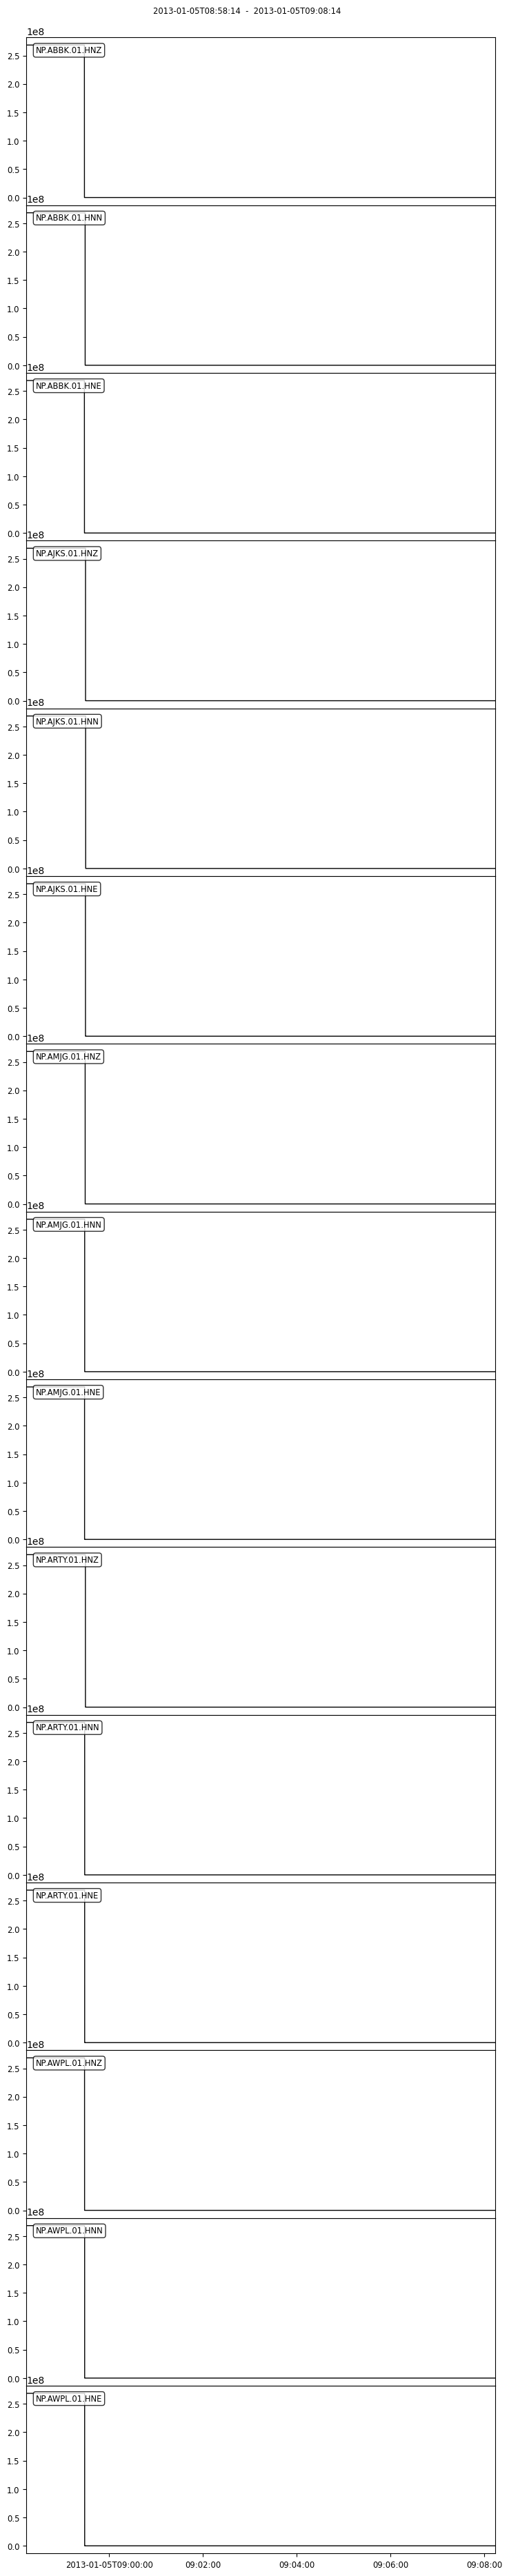

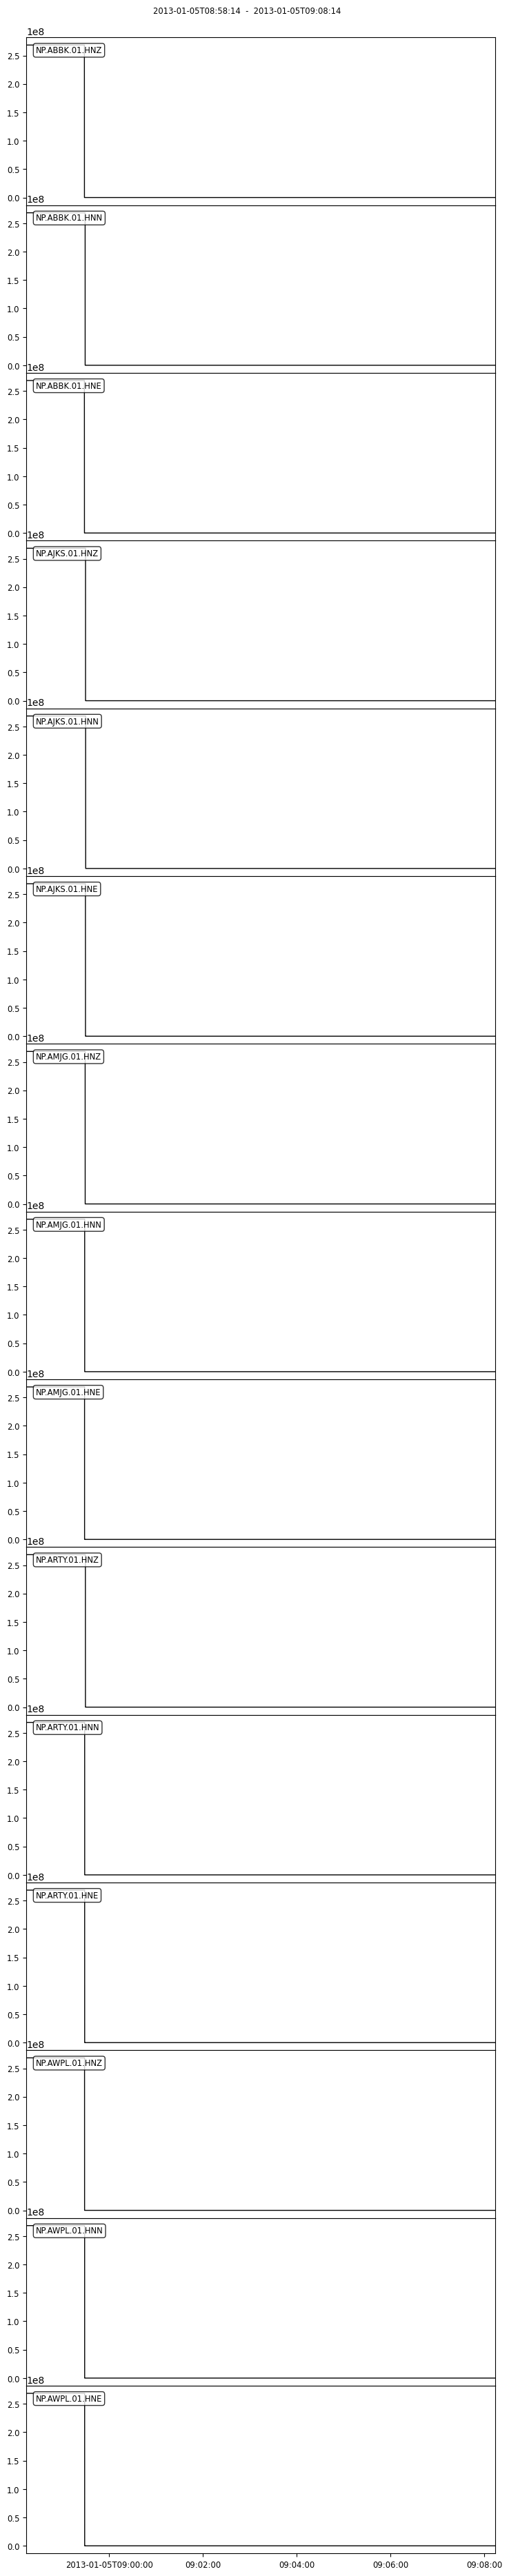

In [126]:
st = read(f'mseeds/{EV_NAME}/*')
st.sort()
inv = read_inventory(f'prep/{EV_NAME}/invfile.xml')
st.trim(starttime=starttime, endtime=endtime)
st.plot()

In [114]:
#test cell for printing stuff
inv[0][1].code

'AJKS'

In [115]:
# 2 loops: for each network in the inv, for each station in the network
for net_cur in inv:
    for sta_cur in net_cur:
    # Get location of current station
        lat = sta_cur.latitude
        lon = sta_cur.longitude
        # Find closest grid point in ShakeMap grid and pga
        subtracted_list = np.hstack((eq.lats - lat, eq.lons - lon))
        nearest_index = np.nanargmin(np.sum(subtracted_list**2, axis=1))
        pga = eq.pga[nearest_index, 0]
        # Calculate epicentral and hypocentral distance, and first-arrival times
        epi_dist = uf.getDistance(eq_lat, eq_lon, lat, lon)
        hypo_dist = (epi_dist**2 + eq_dep**2)**.5
        p_arr = hypo_dist/eq.vel_p
        s_arr = hypo_dist/eq.vel_s
        surf_arr = hypo_dist/eq.vel_surf
        # Save the info into the data dict
        name = sta_cur.code
        station_data[name] = {'lat': lat,
                              'lon': lon,
                              'epi_dist': epi_dist,
                              'hypo_dist': hypo_dist,
                              'pga': pga,
                              'p_arr': p_arr,
                              's_arr': s_arr,
                              'surf_arr': surf_arr}
st_trimmed = st.copy()
st_trimmed.trim(starttime=starttime, endtime=endtime)


15 Trace(s) in Stream:
NP.ABBK.01.HNE | 2013-01-05T08:58:14.000000Z - 2013-01-05T09:08:14.000000Z | 200.0 Hz, 120001 samples
NP.ABBK.01.HNN | 2013-01-05T08:58:14.000000Z - 2013-01-05T09:08:14.000000Z | 200.0 Hz, 120001 samples
NP.ABBK.01.HNZ | 2013-01-05T08:58:14.000000Z - 2013-01-05T09:08:14.000000Z | 200.0 Hz, 120001 samples
NP.AJKS.01.HNE | 2013-01-05T08:58:14.000000Z - 2013-01-05T09:08:14.000000Z | 200.0 Hz, 120001 samples
NP.AJKS.01.HNN | 2013-01-05T08:58:14.000000Z - 2013-01-05T09:08:14.000000Z | 200.0 Hz, 120001 samples
NP.AJKS.01.HNZ | 2013-01-05T08:58:14.000000Z - 2013-01-05T09:08:14.000000Z | 200.0 Hz, 120001 samples
NP.AMJG.01.HNE | 2013-01-05T08:58:14.000000Z - 2013-01-05T09:08:14.000000Z | 200.0 Hz, 120001 samples
NP.AMJG.01.HNN | 2013-01-05T08:58:14.000000Z - 2013-01-05T09:08:14.000000Z | 200.0 Hz, 120001 samples
NP.AMJG.01.HNZ | 2013-01-05T08:58:14.000000Z - 2013-01-05T09:08:14.000000Z | 200.0 Hz, 120001 samples
NP.ARTY.01.HNE | 2013-01-05T08:58:14.000000Z - 2013-01-05T0

15


/tmp/ipykernel_9046/1655268192.py:20: RuntimeWarning: divide by zero encountered in true_divide
  v_app_e = distance/tr_e.times()
/tmp/ipykernel_9046/1655268192.py:21: RuntimeWarning: divide by zero encountered in true_divide
  v_app_n = distance/tr_n.times()
/tmp/ipykernel_9046/1655268192.py:22: RuntimeWarning: divide by zero encountered in true_divide
  v_app_z = distance/tr_z.times()
/tmp/ipykernel_9046/1655268192.py:20: RuntimeWarning: divide by zero encountered in true_divide
  v_app_e = distance/tr_e.times()
/tmp/ipykernel_9046/1655268192.py:21: RuntimeWarning: divide by zero encountered in true_divide
  v_app_n = distance/tr_n.times()
/tmp/ipykernel_9046/1655268192.py:22: RuntimeWarning: divide by zero encountered in true_divide
  v_app_z = distance/tr_z.times()
/tmp/ipykernel_9046/1655268192.py:20: RuntimeWarning: divide by zero encountered in true_divide
  v_app_e = distance/tr_e.times()
/tmp/ipykernel_9046/1655268192.py:21: RuntimeWarning: divide by zero encountered in true_d

Text(0.5, 0, 'Velocity (km/s)')

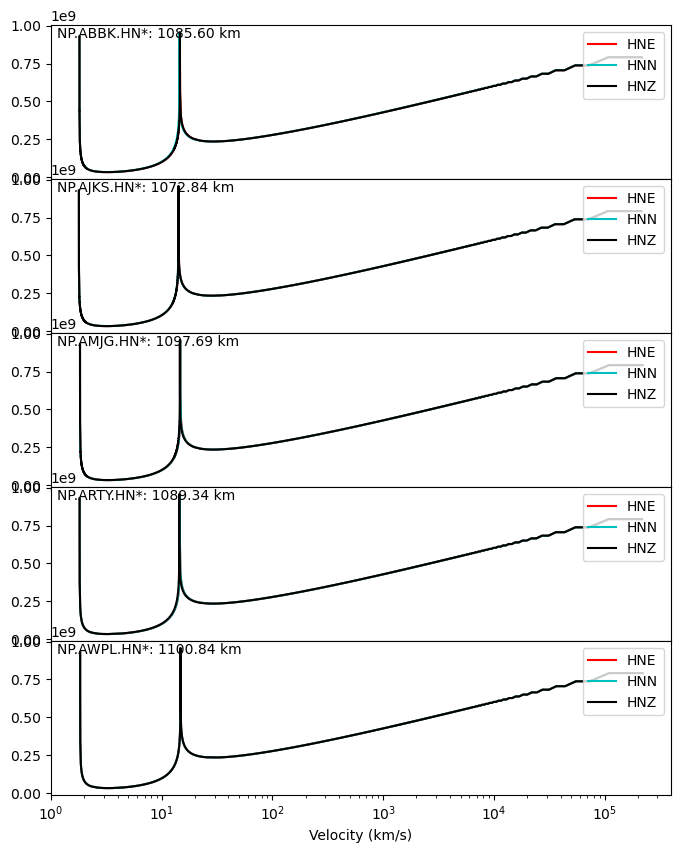

In [116]:
n_tr = len(st)
print(n_tr)
st1 = st_trimmed.copy()

st_acc = st1.copy()
# st_acc.attach_response(inv)
# st_acc = st_acc.remove_response(output='ACC')

fig, ax = plt.subplots(nrows=n_tr // 3, sharex=True, figsize=(8,10))
fig.subplots_adjust(hspace=0)
for i in range(n_tr // 3):
    code = st1[i*3].stats.station
    net = st1[i*3].stats.network
    # chan = st1[i].stats.channel
    distance = station_data[code]['hypo_dist']
    tr_e = st_acc[i*3].detrend('demean')
    tr_n = st_acc[i*3 + 1].detrend('demean')
    tr_z = st_acc[i*3 + 2].detrend('demean')
    # tr_max = np.max(np.abs(np.array(tr_total)))
    v_app_e = distance/tr_e.times()
    v_app_n = distance/tr_n.times()
    v_app_z = distance/tr_z.times()

    ax[i].plot(v_app_e, envelope(tr_e.data), c='r', label=tr_e.stats.channel)
    ax[i].plot(v_app_n, envelope(tr_n.data), c='c', label=tr_n.stats.channel)
    ax[i].plot(v_app_z, envelope(tr_z.data), c='k', label=tr_z.stats.channel)

    ax[i].text(.01, .99, '%s.%s.%s: %.2f km' % (net, code, chan, distance), ha='left', va='top', transform=ax[i].transAxes)
    ax[i].legend(loc='upper right')
    # ax[i].set_title('%s: %.2f km' % (code, distance))
plt.xscale('log')
# plt.xlim(9, 2)
plt.xlabel('Velocity (km/s)')


ValueError: x and y must have same first dimension, but have shapes (120001,) and (5760000,)

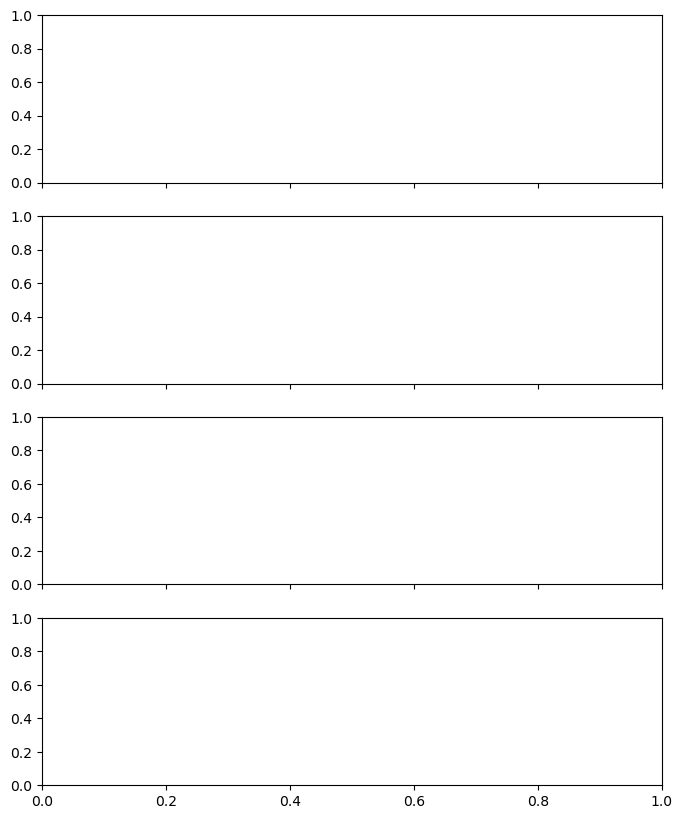

In [117]:
fig, ax = plt.subplots(nrows=4, sharex=True, figsize=(8,10))
for i in range(4):
    code = st1[i].stats.station
    distance = station_data[code]['hypo_dist']
    v_app = distance/st1[i].times()[1:]
    ax[i].plot(st1[i].times(), envelope(st[i].data), c='k')
    ax[i].text(0, np.max(st[i].data[1:])-1000, '%s: %.2f km' % (code, distance), va='top')

In [118]:
st[0].stats.network

'NP'

In [119]:
len(st)

15

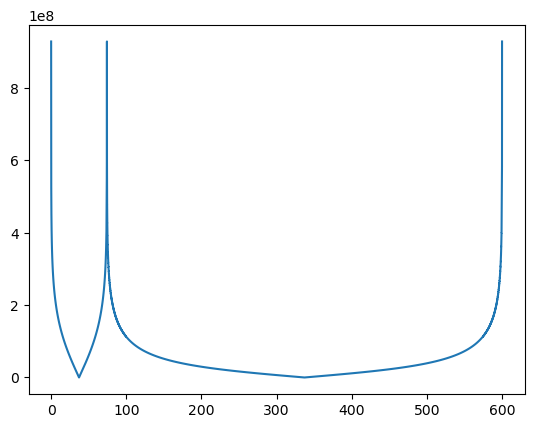

In [120]:
plt.figure()
plt.plot(st1[0].times(), envelope(st1[0].data))

In [121]:
st

15 Trace(s) in Stream:
NP.ABBK.01.HNE | 2013-01-05T08:00:00.000000Z - 2013-01-05T15:59:59.995000Z | 200.0 Hz, 5760000 samples
NP.ABBK.01.HNN | 2013-01-05T08:00:00.000000Z - 2013-01-05T15:59:59.995000Z | 200.0 Hz, 5760000 samples
NP.ABBK.01.HNZ | 2013-01-05T08:00:00.000000Z - 2013-01-05T15:59:59.995000Z | 200.0 Hz, 5760000 samples
NP.AJKS.01.HNE | 2013-01-05T08:00:00.000000Z - 2013-01-05T15:59:59.995000Z | 200.0 Hz, 5760000 samples
NP.AJKS.01.HNN | 2013-01-05T08:00:00.000000Z - 2013-01-05T15:59:59.995000Z | 200.0 Hz, 5760000 samples
NP.AJKS.01.HNZ | 2013-01-05T08:00:00.000000Z - 2013-01-05T15:59:59.995000Z | 200.0 Hz, 5760000 samples
NP.AMJG.01.HNE | 2013-01-05T08:00:00.000000Z - 2013-01-05T15:59:59.995000Z | 200.0 Hz, 5760000 samples
NP.AMJG.01.HNN | 2013-01-05T08:00:00.000000Z - 2013-01-05T15:59:59.995000Z | 200.0 Hz, 5760000 samples
NP.AMJG.01.HNZ | 2013-01-05T08:00:00.000000Z - 2013-01-05T15:59:59.995000Z | 200.0 Hz, 5760000 samples
NP.ARTY.01.HNE | 2013-01-05T08:00:00.000000Z - 201

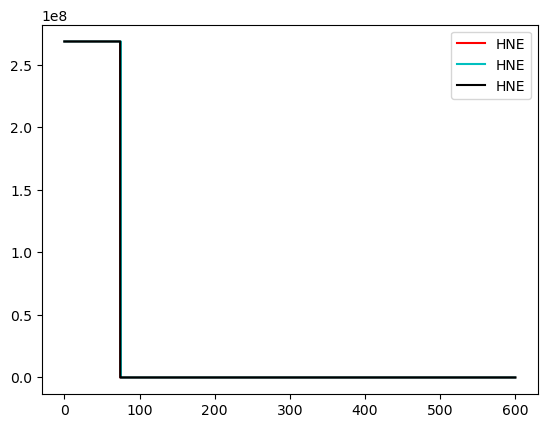

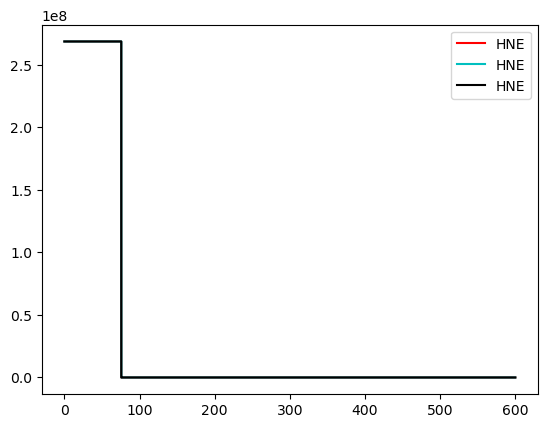

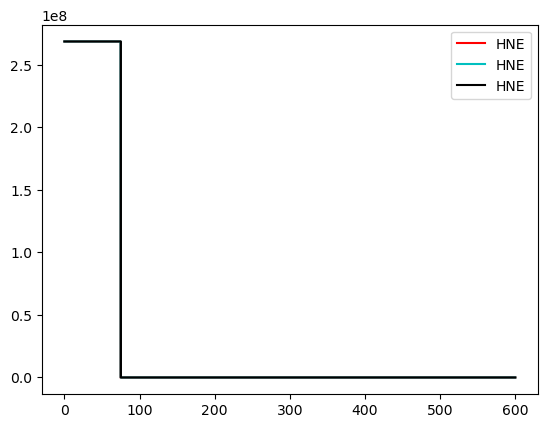

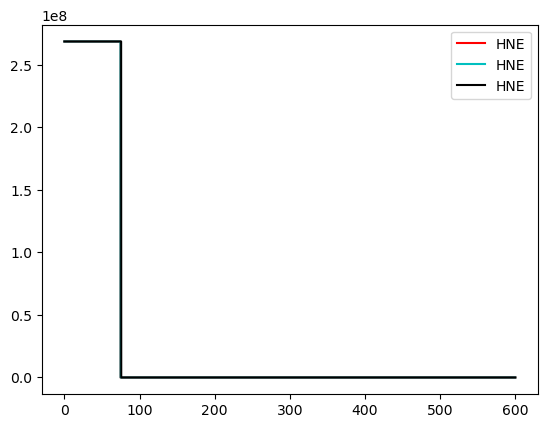

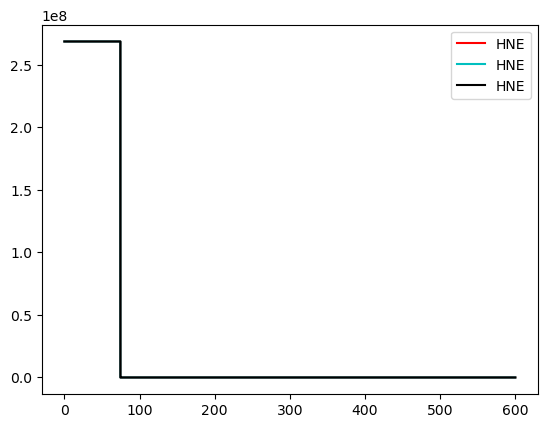

In [122]:
stt = st.copy()
stt.trim(starttime=starttime, endtime=endtime)

for i in range(len(stt)//3):
    plt.figure()
    # st[i].plot()
    code = stt[i*3].stats.station
    net = stt[i*3].stats.network
    # chan = st1[i].stats.channel
    distance = station_data[code]['hypo_dist']
    plt.plot(stt[i*3].times(), stt[i*3].data, c='r', label=stt[i*3].stats.channel)
    plt.plot(stt[i*3+1].times(), stt[i*3+1].data, c='c', label=stt[i*3].stats.channel)
    plt.plot(stt[i*3+2].times(), stt[i*3+2].data, c='k', label=stt[i*3].stats.channel)

    # plt.text(.01, .99, '%s.%s.%s: %.2f km' % (net, code, chan, distance), ha='left', va='top', transform=plt.transAxes)
    plt.legend(loc='upper right')

In [123]:
st[0*3+1].times())

SyntaxError: unmatched ')' (265354340.py, line 1)

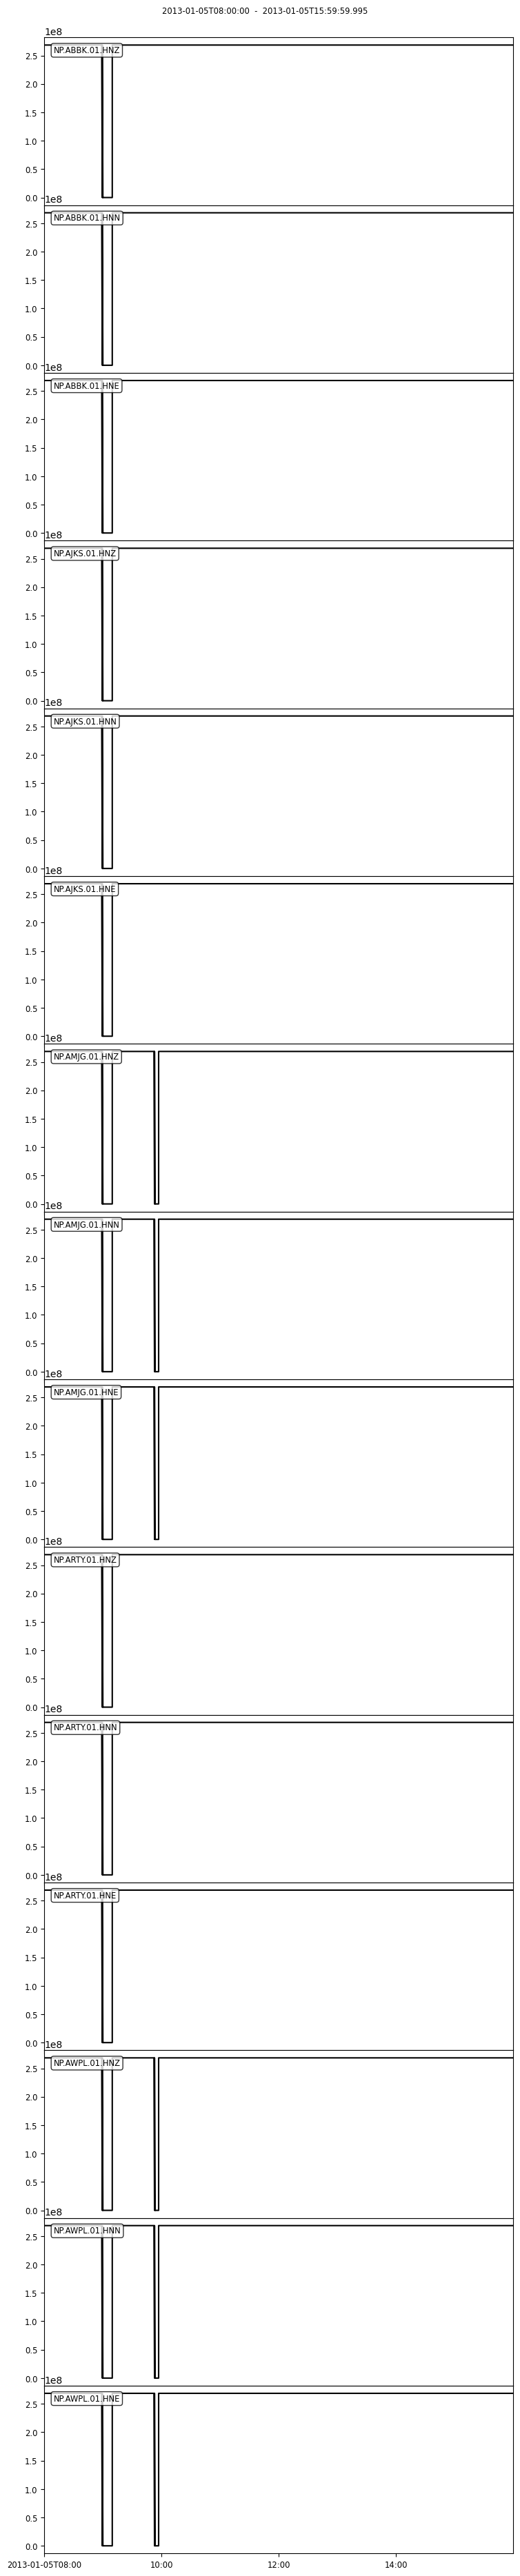

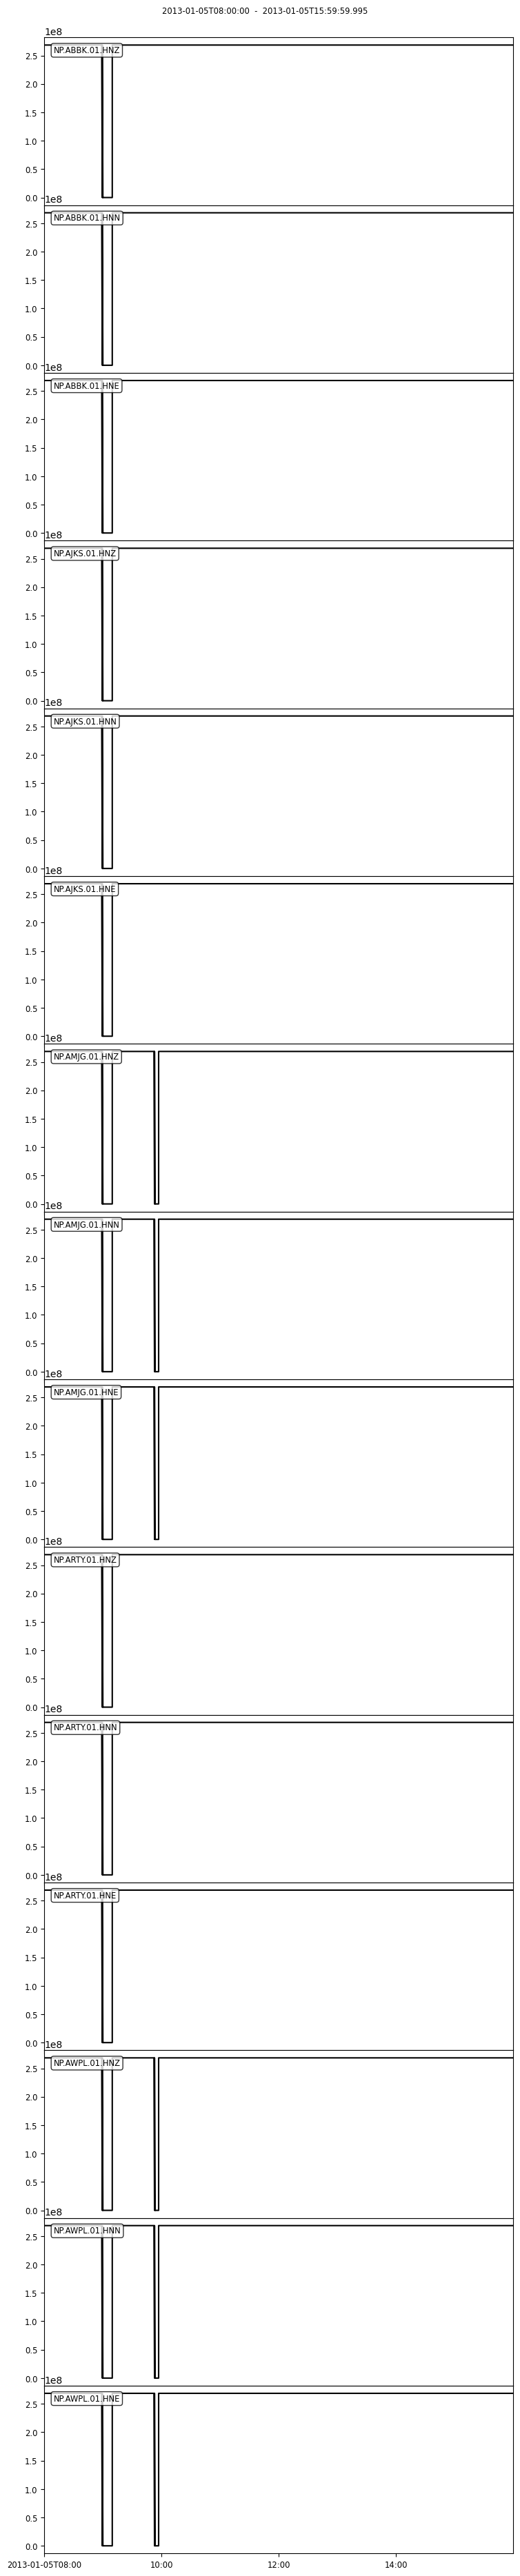

In [124]:
st.plot()